In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob 
import itertools
from PIL import Image
import csv
from sklearn.model_selection import train_test_split
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()

In [144]:
#Resize, flip, convert, normalize images for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224,scale=(0.3, 1.0)),
        #Flip image vertically and horizontally with prob 0.5
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    #Resize and crop images for validation
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    #Resize and crop images for testing (locked away)
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [137]:
#Dataset creation for train, val, test
class MyDataset(torch.utils.data.Dataset):
    """
    The input to this dataset is a directory name.  Inside this directory name,
    the assumption is one level below is a directory for each class we want
    to support:
        images_dir/
            images_dir/class_0/
            images_dir/class_1/
            ...
            
    Then, inside each class directory are image files to be loaded and associated
    with that class.  We will support the following image file extensions:
        .jpg, .jpeg, .gif, 
    """
    def __init__(
        #Needs directory of images, metadata file, and transformations
        self,
        images_dir,
        metadata,
        image_transform,
        lesion_ids,
    ):
        self.lesion_ids = lesion_ids
        self.image_transform = image_transform
        
        # Retrieves class names form metadata file
        self.classes = self.get_class_names(metadata)
        
        # Assign a unique label index to each class name
        self.class_labels = {name: idx for idx, name in enumerate(self.classes)}
        
        # Next, let's collect all image files underneath each class name directory 
        # as a single list of image files.  We need to correspond the class label
        # to each image.
        image_files, labels, info = self.get_image_filenames_with_labels(
            images_dir,
            self.class_labels,
            metadata,
            self.lesion_ids,
        )
        
        # This is a trick to avoid memory leaks over very large datasets.
        self.image_files = np.array(image_files)
        self.labels = np.array(labels).astype("int")
        
        # How many total images do we need to iterate in this entire dataset?
        self.num_images = len(self.image_files)
        
    def __len__(self):
        return self.num_images
        
    def get_class_names(self, metadata):
        #Return all classes as list of strings by iterating through metadata
        class_names = set()
        with open(metadata, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='|')
            next(reader)
            for row in reader:
                class_names.add(row[2])
        
        return sorted(list(class_names)) #convert set to list and return
    
    #The images are organized cleanly, all ending with .jpg, and with uniform naming structure
    def get_image_filenames_with_labels(self, images_dir, class_labels, metadata, lesion_ids):
        image_files = []
        labels = []
        info = []
        
        #Iterate over all lesions in the specific set
        all_data = pd.read_csv(metadata)
        for lesion_id in lesion_ids:
            results = all_data.loc[all_data['lesion_id'] == lesion_id]
            
            #For each image of the lesion
            #add the image name, label, and demographic info to the lists
            results = results.reset_index()
            for index, row in results.iterrows():
                image_files += [images_dir + '/' + (row['image_id'] + '.jpg')]
                labels += [class_labels[row['dx']]]
                info += (row['lesion_id'], row['dx_type'], row['age'], 
                         row['sex'], row['localization'],)
        return image_files, labels, info
    
    def __getitem__(self, idx):  
        # Retrieve an image from the list, load it, transform it, 
        # and return it along with its ground truth label.  Sometimes
        # we get bad images so check for exceptions opening image files.
        # When this happens, there are various things we can do.  I will
        # choose to return None and handle this in the data collator.
        # You could also just randomly choose another example to return,
        # until success.  It's up to you.
        try:
            # Try to open the image file and convert it to RGB.  This makes
            # this cleaner and consistent assuming the same color type.
            # Even if it's gray-scale, it will replicate the color channels
            # 3 times.
            image = Image.open(self.image_files[idx]).convert('RGB')
            label = self.labels[idx]
            #info = self.info[idx]
            
            # Apply the image transform
            image = self.image_transform(image)
            
            return image, label
        except Exception as exc:  # <--- i know this isn't the best exception handling
            return None

In [61]:
def collate_fn(batch):
    # Filter failed images first
    batch = list(filter(lambda x: x is not None, batch))
    
    # Now collate into mini-batches
    images = torch.stack([b[0] for b in batch])
    labels = torch.LongTensor([b[1] for b in batch])
    
    return images, labels

In [62]:
# Returns the lesion IDs for each split
def train_val_test_split(metadata):
    
    #Read in metadata and separate lesions (not images) into training, test, and validation groups
    #Train = 60% of lesions
    #Val = 20% of lesions
    #Test = 20% of lesions
    df = pd.read_csv(metadata)
    train_les, eval_les = train_test_split(df['lesion_id'].drop_duplicates(), test_size=0.4, random_state=0)
    val_les, test_les = train_test_split(eval_les, test_size=0.5, random_state=0)
    
    return {'train': train_les, 'val': val_les, 'test': test_les}


In [63]:
#Set metadata file and image data directory
data_dir = './HAM10000_images'
metadata = 'HAM10000_metadata.csv'

In [145]:
#Split lesions into sets
splits = train_val_test_split(metadata)

#create datasets
image_datasets = {x: MyDataset(data_dir, metadata, data_transforms[x], sorted(list(splits[x]))) for x in ['train','val','test']}

In [173]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0, collate_fn=collate_fn)
              for x in ['train', 'val']}

In [174]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 6022, 'val': 1992, 'test': 2001}
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [157]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [121]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([4, 3, 224, 224])
tensor([5, 5, 4, 1])
torch.Size([3, 228, 906])


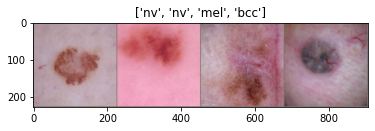

In [150]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title=[class_names[x] for x in classes])

In [175]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [155]:
# Here is a generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [165]:
# Load a pretrained model and reset final fully connected layer for this particular classification problem.
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 7)

# Move the model to the correct device (when we have access to a GPU)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/joshuauhlfelder/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [166]:
# Let's set our loss function
criterion = nn.CrossEntropyLoss()

In [167]:
# Setup the optimizer to update the model parameters
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)

In [168]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [176]:
# Train and evaluate.  
# It should take around 10 min on CPU. On GPU, it takes less than a minute.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

  0%|          | 0/1506 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/1506 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft)

In [ ]:
# The previous experiment updated all of the weights of the model, from end to end.
# Sometimes we want to freeze the pre-trained model and only update the classifier head.
# This turns the pre-trained model into a "feature extractor".

# Load in the pre-trained model as before.
model_conv = torchvision.models.resnet34(pretrained=True)

# This loop freezes all of the parameters of the model so that when we do backprop, these
# weights never change.
for param in model_conv.parameters():
    param.requires_grad = False

In [ ]:
# Now we can replace the classifier head, as before.  But these weights will actually
# be updated.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 7)

# Move the model to the correct device (when we have access to a GPU)
model_conv = model_conv.to(device)

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.00001, momentum=0.9)

In [ ]:
# Train and evaluate again.  Note that this trains much faster, even on the CPU.
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
# What if we train end to end without pre-training?
model_sc = models.resnet18(pretrained=False)  # <-- note no loading pre-traiend weights

num_ftrs = model_sc.fc.in_features
model_sc.fc = nn.Linear(num_ftrs, 2)
model_sc = model_sc.to(device)

optimizer_sc = optim.SGD(model_sc.parameters(), lr=0.001, momentum=0.9)

model_sc = train_model(model_sc, criterion, optimizer_sc, exp_lr_scheduler,
                       num_epochs=10)

In [ ]:
# How do we cut out the last few layers of the model? For example, we want to expose the final
# convolutional output
model = nn.Sequential(*list(model.children())[:-1])